In [1]:
import gym
env = gym.make("Taxi-v3", render_mode="ansi").env

In [2]:
# Agent's Actions
# 0- drive down
# 1- drive up
# 2- drive right
# 3- drive left
# 4- pick up a passenger
# 4- pick down a passenger

print("Action Space {}".format(env.action_space))

Action Space Discrete(6)


In [3]:
# How many state there are?
# 25 position for the taxi 
# 5 options for a passenger 
# 4 options as destiny 
# So, 25 * 5 * 4 = 500

print("State Space {}".format(env.observation_space))

State Space Discrete(500)


In [4]:
# env.P is double dictionary.
# - The 1st key represents the state, from 0 to 499
# - The 2nd key represens the action taken by the agent,
#   from 0 to 5

# example
state = 123
action = 0  # move south

# env.P[state][action][0] is a list with 4 elements
# (probability, next_state, reward, done)
# 
#  - probability
#    It is always 1 in this environment, which means
#    there are no external/random factors that determine the
#    next_state
#    apart from the agent's action a.
#
#  - next_state: 223 in this case
# 
#  - reward: -1 in this case
#
#  - done: boolean (True/False) indicates wheter the
#    episode has ended (i.e. the driver has dropped the
#    passenger at the correct destination)
print('env.P[state][action][0]: ', env.P[state][action][0])

env.P[state][action][0]:  (1.0, 223, -1, False)


In [5]:
# Need to call reset() at least once before render() will work
env.reset(seed=0)
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [6]:
# If we use the same seed the env always initialize as the same way 
env.reset(seed=0)
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [7]:
class RandomAgent:
    """
    This taxi driver selects actions randomly.
    You better not get into this taxi!
    """
    def __init__(self, env):
        self.env = env

    def get_action(self, state) -> int:
        """
        We have `state` as an input to keep
        a consistent API for all our agents, but it
        is not used.
        
        i.e. The agent does not consider the state of
        the environment when deciding what to do next.
        This is why we call it "random".
        """
        return self.env.action_space.sample()

# agent = RandomAgent(env)

In [8]:

def run(agent, env, seed = 0):
    # set initial state of the environment
    state = env.reset(seed=0)[0]

    epochs = 0
    penalties = 0  # wrong pick up or dropp off
    reward = 0

    # store frames to latter plot them
    frames = []

    done = False

    while not done:

        action = agent.get_action(state)

        state, reward, done, _, info = env.step(action) 

        if reward == -10:
            penalties += 1

        frames.append({
            'frame': env.render(),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        epochs += 1


    print("Timesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    return frames

In [9]:
import numpy as np

class QAgent:

    def __init__(self, env, learning_rate, discount_factor):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor 

    def get_action(self, state):
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """
        Q-learning is a non-policy algorithm.The agent's learning 
        is only based on past experiences. The agent's learning is 
        only based on past experiences. Disregarding the current 
        state and the possible next decision according to the 
        agent's policy.

        Note: But, the truth is that this agent does not use the 
              agent's policy, since it always uses the same one 
              to maximize the reward.
        """

        # Q-learning formula
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        delta = self.learning_rate * (reward + self.discount_factor * next_max - old_value)

        # update the q_table
        self.q_table[state, action] += delta

agent = QAgent(env, 0.1, 0.6)

In [10]:
import random
from tqdm import tqdm

def train(agent, env, min_epsilon = 0.1, epsilon = 0.5, epsilon_step = 0.005, n_episodes= None):
    if n_episodes is None:
        observations = env.observation_space.n
        n_episodes = 200 * observations
    

    n_episodes = 10000

    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []


    for i in tqdm(range(0, n_episodes)):

        state = env.reset()[0]
        #exploration vs exploitation prob
        epsilon = epsilon - i * epsilon_step if epsilon > min_epsilon else min_epsilon
        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, _, info = env.step(action) 

            agent.update_parameters(state, action, reward, next_state)

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)
    
    return (timesteps_per_episode, penalties_per_episode)

timesteps_per_episode, penalties_per_episode = train(agent, env)

100%|██████████| 10000/10000 [00:04<00:00, 2078.55it/s]


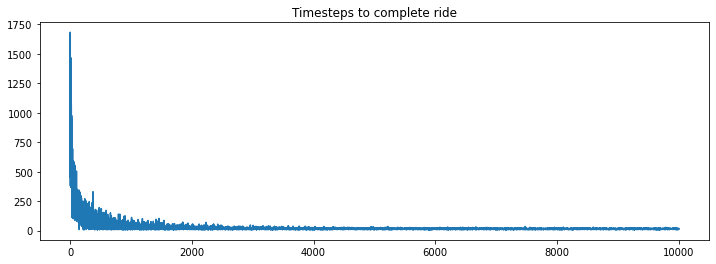

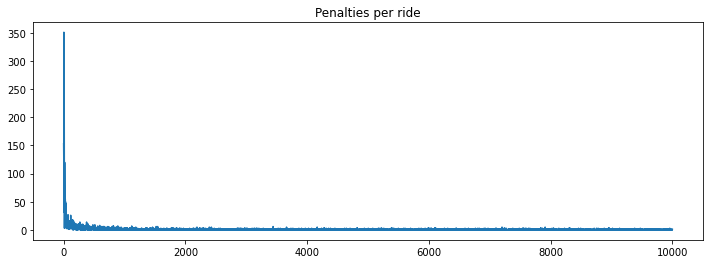

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

In [12]:
frames = run(agent, env)     

Timesteps taken: 15
Penalties incurred: 0


In [14]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 15 of 15
State: 410
Action: 5
Reward: 20
